<a href="https://colab.research.google.com/github/lalit-jamdagnee/Learning_ML/blob/main/Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Like *SVMs*, **Decision Trees** are versatile Machine Learning algorithms that can perform both classification and regression tasks, and even multioutput taks. They are powerful algorithms, capable of fitting complex datasets.

Decision Trees are also the fundamental components of Random Forests which are among the most powerful Machine Lerning algorithms available today.

In this chaper we will start by discussing how to train, visualize, and make predictions with Decision Trees. Then we will go through the CART training algorithm used by Scikit-Learn, and we will discuss how to regularize trees and use them for regression tasks. Finally, we will descuss some of the limitations of Decision Trees.

# Training and Visualizing a Decision Tree

To understand Decision Trees, let's build one and take a look at how it makes predictions. The following code trains a DecisionTreeClassifier on the iris dataset:

In [4]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal lenght, petal width
y = iris.target


In [5]:
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

In [33]:
!apt-get install -y graphviz
!pip install graphviz pydotplus


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


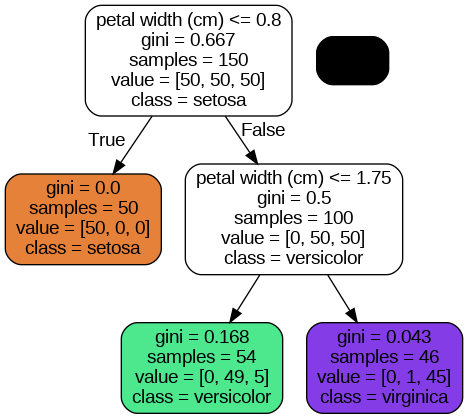

In [34]:
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from IPython.display import Image

# Export the decision tree to a .dot file
dot_data = export_graphviz(
    tree_clf,
    out_file=None,  # Don't write to file, generate as string
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

# Use graphviz to convert .dot to a graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Display the graph in Colab
Image(graph.create_png())


# Making Predictions

Let's see how the tree generated above make predictions. Suppose you find an iris flower and you want to classify it. You start at the *root node* (depth 0, at the top): This node asks whether the flower's petal length is smaller than 2.45 cm. If it is, then you move down to its root's left child node (depth 1, left). In this case, it is a *leaf node* (i.e., it does not have any chld nodes), so it gives the prediction for that node i.e. your flower is *Iris setosa* **(class = setosa)**.

Now suppose you find another flower, adn this time the petal length is greater than 2.45cm. You must move down to the root's child node (depth 1, right), which is not a leaf node, so the node asks another question: is the petal width smaller than 1.75cm? If it is, then your flower is mostlikely an *Iris versicolor* (depth 2, left). If not, it is likely an *Iris virginica* (depth 2, right). It's really that simple.

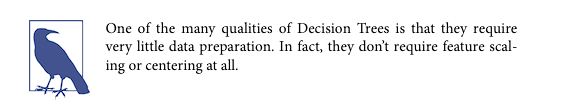

A node's **samples** attribute counts how many training instances it applies to. For example, 100 training instances have a petal length greater than 2.45 cm (depth 1, right), and of those 100, 54 have a petal width smaller than 1.75cm (depth2, left).

A node's **value** attribute tells you how many training instances of each class this node applies to: for example, the bottom-right node applies to 0 *Iris setosa*, 1 *Iris versicolor*, and 45 *Iris virginica*.

Finally, a node's **gini** attribute measures its *impurity*: a node is "pure" (gini = 0) if all training instances it applies to belong to the same class. For example, since the depth-1 left node applies only to *Iris setosa* training instances, it is pure and its **gini** score is 0.

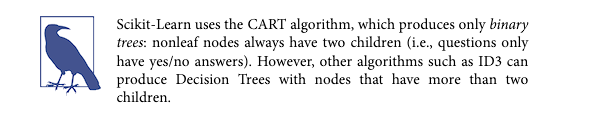

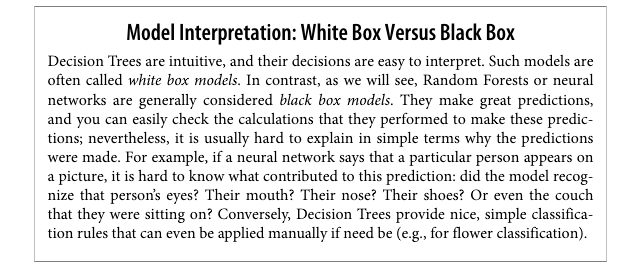

# Estimating Class Probabilities

A Decision Tree can also estimate the probability that an instance belongs to a particular class k. First it traverses the tree to find the leaf node for this instance, and then it returns the ratio of training instances of class k in this node.

For example, suppose you have found a flower whose petals are 5cm long and 1.5cm wide. The corresponding leaf node is the depth-2 left node, so The decision Tree should output the following probabilities: 0% for *Iris setosa* (0/54), 90.7% for the *Iris versicolor* (49/54), and 9.3% for *Iris viriginica* (5/54). And if ou ask it to predict the class, it should output *Iris versicolor* (class 1) because it has the highest probability. Let's check this:

In [35]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [36]:
tree_clf.predict([[5, 1.5]])

array([1])

# The CART Training Algorithm

Scikit-Learn uses the **Classification and Regression Tree (CART** algorithm to train Decision Trees (also called "growing" trees). The algorithm works by first splitting the training set into two subsets using a single feature k and a threshold tk (e.g., "petal length <= 2.45cm ").

It chooses k and tk by searching for the pair (k, tk) that produces the purest subsets (weighted by their size).

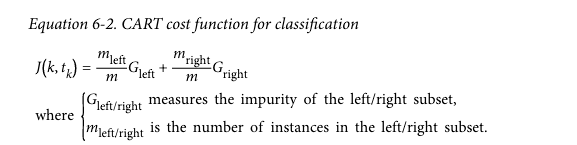

Once the **CART** algorithm has successfully split the training set in two, it splits the subsets using the same logic, then the sub-subsets, and so on, recursively. It stops recursing once it reaches the maximum depth (defined by the **max_depth** hyperparameter), or if it cannot find a split that will reduce impurity.

A few other hyperparameters control additional stopping conditions (**min_samples_split, min_samples_leaf, min_weight_fraction_leaf,** and **max_leaf_nodes**).

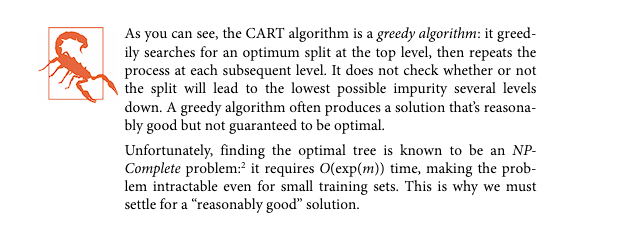

# Computational Complexity

Making predictions requires traversing the Decision Tree from the root to a leaf. Decision Trees generally are approximately balanced, so traversing the Decision Tree requires going through roughly **O(log(m))** nodes. Since each node only requires checking the value of one feature, the overall prediction complexity is **O(log(m)), independent of the number of features. So predicitons are very fast, even when dealing with large training sets.

The training algorithm compares all features on all samples at each node. Compairing all features on all sample at each node results in training complexity of **O(n x mlog(m))**. for small training sets (instances <= few thousands), Scikit-Learn can speed up training by presorting the data ( set **presort=True**), but doing that slows down training considerably for larger training sets.

# Gini Impurity or Entropy?

By default, the Gini impurity measure is used, but you can select the *entropy* impurity measure instead by setting the **criterion** hyperparamter to **"entropy"**.

Most of the time it does not make a big difference: they lead to similar trees, Gini impurity is slightly faster to compute, so it is a good default. However, when they differ, Gini impurity tends to isolate the most frequent class in its own branch of the tree, while entropy tends to produce slightly more balanced trees.

# Regurlarization Hyperparameters

Decision Trees make very few assumptions about the training data (as opposed to linear models, which assume that the data is linear, for example). If left unconstrained, the tree structure will adapt itself to the training data, fitting it very closely - indeed, most likely overfitting it. Such a model is often called a **nonparametric model**, not because it does not have any parameters but because the number of parameters is not determined prior to training, so the model structure is free to stick closely to the data. In contrast, a **parameteric model**, such as a linear model, has a predetermined number of parameters, so its degree of freedom is limited, reducing the risk of overfitting (but increasing the risk of underfitting).

To avoid overfitting the training data, you need to restrict the Decision Tree's freedom during training. As you konw by now, this is calle regularization. The regularization hyperparameters depend on the algorithm used, but generally you can at least restrict the maximum depth of the Decision Tree. In Scikit-learn, this is controlled by the **max_depth** hyperparameter ( the default value is **None**, which means unlimited). Reducing **max_depth** will regularize the model and thus reduce the risk of overfitting.

The **DecisionTreeClassifier** calss has a few other parameters that similarly restrict the shape of the Decision tree:

* **min_samples_split** (the minimum number of samples a node must have before it can be split)

* **min_samples_leaf** (the minimum number of samples a leaf node must have)

* **min_weight_fraction_leaf** (same as the **min_samples_leaf** but expressed as a fraction of the total number of weighted instances)

* **max_leaf_nodes** (the maximum number of leaf nodes),

* **max_features** (the maximum number of features that are evaluated for splitting at each node).

Increasing **min_*** hyperparameters or reducing **max_*** hyperparameters will regularize the model.

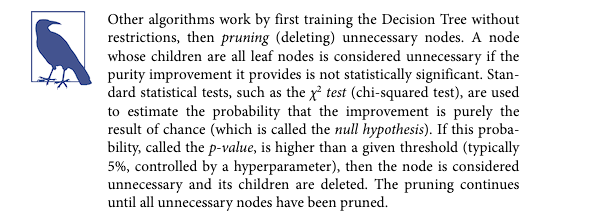

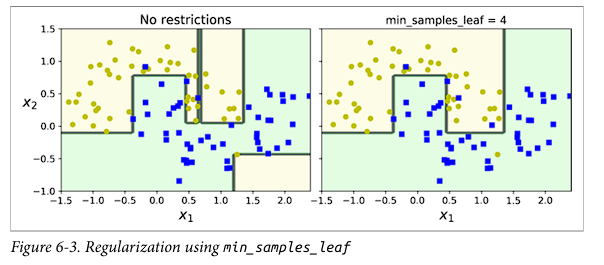

# Regression

Decision Trees are also capable of performing regression tasks. Let's build a regression tree using Scikit-Learn's **DecisionTreeRegressor** class, trainign it on a noisy quadratic dataset witih **max_depth=2**

In [37]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth =2)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2)

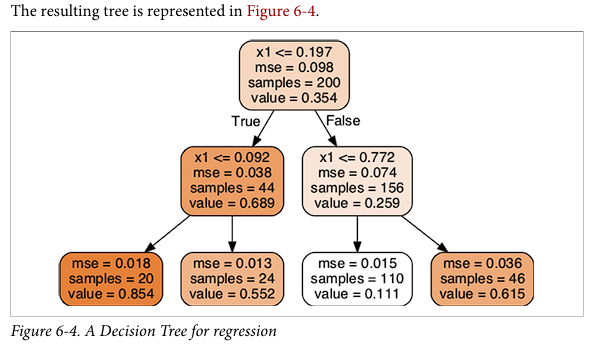

This tree looks very similar to the classification tree we built earlier. The main difference is that instead of predicting a class in each node, it predicts a value. For example, suppose you want to make a prediction for a new instance with x1 = 0.6. You traverse the tree starting at the root, and you eventually reach the leaf node that predicts **value = 0.111**. The prediction is the average target value of the 110 training instances associated with this leaf node, and it results in a mean squared error equal to 0.015 over these 110 instances.

This model's prediction are represented in the left plot in the figure below. If you set max_depth=3, you get the predictions represented on the right. Notice how the predicted value for each region is always the average target value of the instances in that region. The algorithm splits each region in a way that makes most training instances as close as possible to that predicted value.

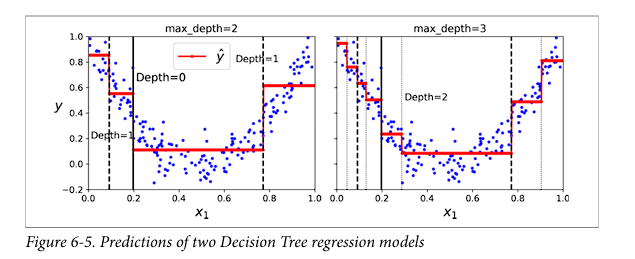

The CART algorithm works mostly the same way as earlier, except that instead of trying to split the training set in a way that minimizes impurity, it now tries to split the training set in a way the minimizes the **MSE**.

Just like for classification tasks, Decision Trees are prone to overfitting when dealing with regression tasks. WIthout any regularization, you get the prediction on the left plot below. These predictions are obviously overfitting the training set very badly. Just setting the **min_samples_leaf=10** results in a much more reasonable model, represented on the right.

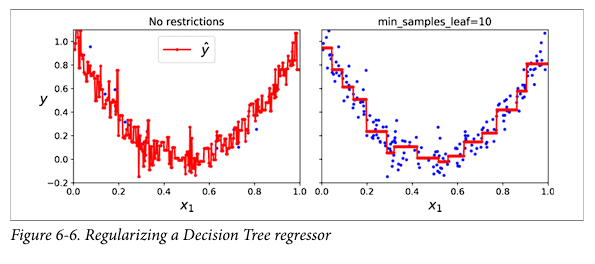

# Instability

Decision Trees are simple to understand and intercept, easy to use, versatile, and powerful. However, they do have a few limitations. First, as you may have noticed, Decsion trees love orthogonal decisional boundaries (all splits are perpendicualr to an axis), which makes them sensitive to training set rotation.

For example, the figure below shows a simple linearly separable datset: when we rotate the dataset by 45%, the decision boundary looks unecessary complicated and thus making the tree overfit. One way to limit this problem is to use Principal Component Analysis which results in better orientation of the training data


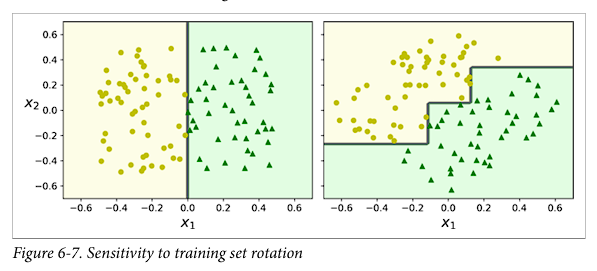

More generally, the main issue with Decision Trees is that they are very sensitive to small variations in the training data. For example, if you just remove the widest *Iris versicolor* from the iris training set and trains a new Decision Tree, you get a very different decision tree ( see the figure below ).
Actually, the training algorithm used by Scikit-Learn is stochastic ( it randomly selects the set of features to evaluate at each node ), you may get very different models even on the same training data

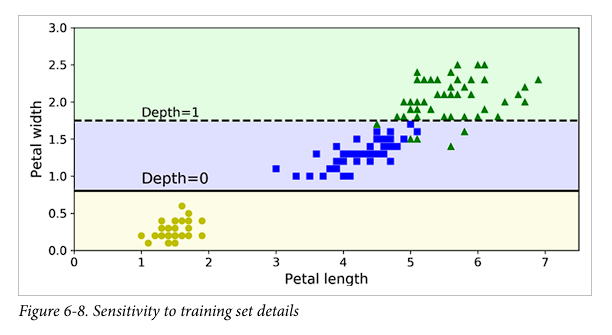

Random Forest can limit this instability by averaging predictions over many trees.